# REINFORCE: Your First Policy Gradient

**Goal**: Transition from value-based methods to directly learning a policy.

## Why Policy Gradients?

**Value-based** (DQN, Q-learning):
- Learn Q(s,a), derive policy as argmax
- Only works for discrete actions
- Can't represent stochastic policies

**Policy-based** (REINFORCE, PPO):
- Directly parameterize and optimize the policy π(a|s; θ)
- Works for continuous actions
- Can learn stochastic policies
- Foundation for RLHF (PPO fine-tunes LLM policies!)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from collections import deque

device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

Using device: mps


---
## 1. The Policy Gradient Theorem

We want to maximize expected return:

$$J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta}\left[\sum_t R_t\right]$$

The **policy gradient theorem** gives us:

$$\nabla_\theta J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta}\left[\sum_t \nabla_\theta \log \pi_\theta(a_t|s_t) \cdot G_t\right]$$

Where $G_t = \sum_{k=t}^{T} \gamma^{k-t} r_k$ is the **return from time t**.

### Intuition
- $\log \pi(a|s)$: Direction to make action $a$ more likely in state $s$
- $G_t$: How good was the outcome?
- **If G_t is high**: Push policy toward that action (increase probability)
- **If G_t is low**: Push policy away from that action (decrease probability)

---
## 2. REINFORCE Algorithm

```
for each episode:
    1. Collect full trajectory τ = (s₀, a₀, r₀, s₁, a₁, r₁, ...)
    2. Compute returns Gₜ for each timestep
    3. Compute loss = -Σ log π(aₜ|sₜ) · Gₜ
    4. Backprop and update θ
```

**Key limitation**: Must wait for full episode (Monte Carlo). High variance.

In [2]:
class PolicyNetwork(nn.Module):
    """Simple MLP policy network."""
    
    def __init__(self, obs_dim: int, n_actions: int, hidden_dim: int = 128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, n_actions),
        )
    
    def forward(self, x):
        return self.net(x)
    
    def get_action(self, state):
        """Sample action from policy and return (action, log_prob)."""
        logits = self.forward(state)
        dist = Categorical(logits=logits)
        action = dist.sample()
        return action.item(), dist.log_prob(action)

In [3]:
def compute_returns(rewards: list, gamma: float = 0.99) -> torch.Tensor:
    """
    Compute discounted returns for each timestep.
    
    G_t = r_t + γ r_{t+1} + γ² r_{t+2} + ...
    
    Args:
        rewards: List of rewards from one episode
        gamma: Discount factor
    
    Returns:
        Tensor of returns for each timestep
    """
    returns = []
    G = 0
    for r in reversed(rewards):
        G = r + gamma * G
        returns.insert(0, G)
    
    returns = torch.tensor(returns, dtype=torch.float32)
    # Normalize returns (reduces variance significantly)
    if len(returns) > 1:
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)
    return returns

In [4]:
def train_reinforce(env_id="CartPole-v1", n_episodes=1000, gamma=0.99, lr=1e-2):
    """
    Train a REINFORCE agent.
    
    Args:
        env_id: Gymnasium environment ID
        n_episodes: Number of training episodes
        gamma: Discount factor
        lr: Learning rate
    
    Returns:
        Tuple of (trained policy, reward history)
    """
    env = gym.make(env_id)
    obs_dim = env.observation_space.shape[0]
    n_actions = env.action_space.n
    
    policy = PolicyNetwork(obs_dim, n_actions).to(device)
    optimizer = optim.Adam(policy.parameters(), lr=lr)
    
    reward_history = []
    
    for episode in range(n_episodes):
        state, _ = env.reset()
        log_probs = []
        rewards = []
        
        # Collect episode
        done = False
        while not done:
            state_t = torch.FloatTensor(state).to(device)
            action, log_prob = policy.get_action(state_t)
            
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            log_probs.append(log_prob)
            rewards.append(reward)
        
        # Compute returns and loss
        returns = compute_returns(rewards, gamma).to(device)
        log_probs = torch.stack(log_probs)
        
        # REINFORCE loss: -E[log π(a|s) * G_t]
        loss = -(log_probs * returns).sum()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_reward = sum(rewards)
        reward_history.append(total_reward)
        
        if (episode + 1) % 100 == 0:
            avg = np.mean(reward_history[-100:])
            print(f"Episode {episode+1}: avg reward = {avg:.1f}")
    
    env.close()
    return policy, reward_history

In [5]:
# Train REINFORCE on CartPole
policy, rewards = train_reinforce(n_episodes=1000, lr=1e-2)

Episode 100: avg reward = 61.7
Episode 200: avg reward = 135.0
Episode 300: avg reward = 179.2
Episode 400: avg reward = 97.2
Episode 500: avg reward = 230.9
Episode 600: avg reward = 275.8
Episode 700: avg reward = 62.8
Episode 800: avg reward = 168.6
Episode 900: avg reward = 229.1
Episode 1000: avg reward = 164.7


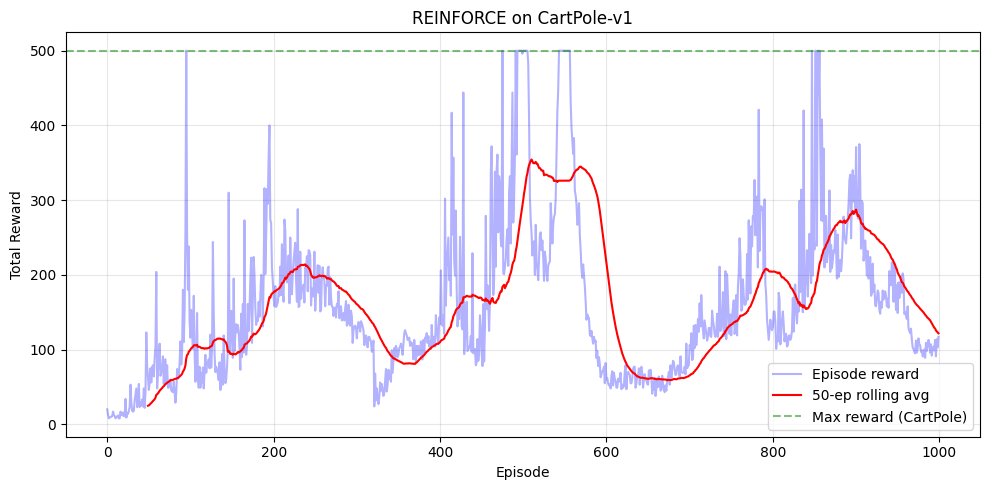

In [6]:
# Plot training curve
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(rewards, alpha=0.3, color='blue', label='Episode reward')
# Rolling average
window = 50
rolling = np.convolve(rewards, np.ones(window)/window, mode='valid')
ax.plot(range(window-1, len(rewards)), rolling, color='red', label=f'{window}-ep rolling avg')

ax.axhline(y=500, color='green', linestyle='--', alpha=0.5, label='Max reward (CartPole)')
ax.set_xlabel('Episode')
ax.set_ylabel('Total Reward')
ax.set_title('REINFORCE on CartPole-v1')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
## 3. REINFORCE with Baseline

**Problem**: REINFORCE has high variance because returns can vary wildly.

**Solution**: Subtract a baseline $b(s)$ from the returns:

$$\nabla_\theta J = \mathbb{E}\left[\sum_t \nabla_\theta \log \pi_\theta(a_t|s_t) \cdot (G_t - b(s_t))\right]$$

This is **still unbiased** (the baseline cancels out in expectation) but reduces variance.

Common baseline: **Value function** $V(s)$ → This gives us the **advantage**: $A(s,a) = G_t - V(s_t)$

In [7]:
class PolicyWithBaseline(nn.Module):
    """Policy + value network (shared backbone)."""
    
    def __init__(self, obs_dim: int, n_actions: int, hidden_dim: int = 128):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim),
            nn.ReLU(),
        )
        self.policy_head = nn.Linear(hidden_dim, n_actions)
        self.value_head = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        features = self.shared(x)
        logits = self.policy_head(features)
        value = self.value_head(features)
        return logits, value.squeeze(-1)
    
    def get_action(self, state):
        """Sample action and return (action, log_prob, value)."""
        logits, value = self.forward(state)
        dist = Categorical(logits=logits)
        action = dist.sample()
        return action.item(), dist.log_prob(action), value

In [8]:
def train_reinforce_baseline(env_id="CartPole-v1", n_episodes=1000, gamma=0.99, lr=1e-2):
    """
    Train REINFORCE with value baseline.
    
    Args:
        env_id: Gymnasium environment ID
        n_episodes: Number of training episodes
        gamma: Discount factor
        lr: Learning rate
    
    Returns:
        Tuple of (trained model, reward history)
    """
    env = gym.make(env_id)
    obs_dim = env.observation_space.shape[0]
    n_actions = env.action_space.n
    
    model = PolicyWithBaseline(obs_dim, n_actions).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    reward_history = []
    
    for episode in range(n_episodes):
        state, _ = env.reset()
        log_probs = []
        values = []
        rewards = []
        
        done = False
        while not done:
            state_t = torch.FloatTensor(state).to(device)
            action, log_prob, value = model.get_action(state_t)
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            log_probs.append(log_prob)
            values.append(value)
            rewards.append(reward)
        
        returns = compute_returns(rewards, gamma).to(device)
        log_probs = torch.stack(log_probs)
        values = torch.stack(values)
        
        # Advantage = Return - Baseline(value)
        advantages = returns - values.detach()
        
        # Policy loss: use advantage instead of raw return
        policy_loss = -(log_probs * advantages).sum()
        # Value loss: train baseline to predict returns
        value_loss = nn.functional.mse_loss(values, returns)
        
        loss = policy_loss + 0.5 * value_loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_reward = sum(rewards)
        reward_history.append(total_reward)
        
        if (episode + 1) % 100 == 0:
            avg = np.mean(reward_history[-100:])
            print(f"Episode {episode+1}: avg reward = {avg:.1f}")
    
    env.close()
    return model, reward_history

In [9]:
# Train REINFORCE with baseline
model_baseline, rewards_baseline = train_reinforce_baseline(n_episodes=1000, lr=1e-2)

Episode 100: avg reward = 237.4
Episode 200: avg reward = 430.7
Episode 300: avg reward = 405.0
Episode 400: avg reward = 110.0
Episode 500: avg reward = 190.7
Episode 600: avg reward = 211.0
Episode 700: avg reward = 342.8
Episode 800: avg reward = 397.0
Episode 900: avg reward = 460.1
Episode 1000: avg reward = 495.6


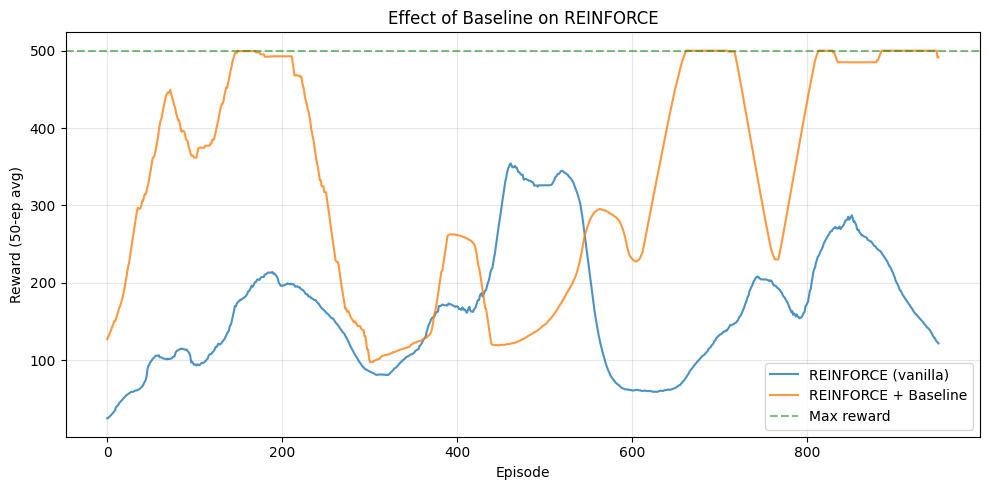

In [10]:
# Compare vanilla vs baseline
fig, ax = plt.subplots(figsize=(10, 5))

window = 50
r1 = np.convolve(rewards, np.ones(window)/window, mode='valid')
r2 = np.convolve(rewards_baseline, np.ones(window)/window, mode='valid')

ax.plot(r1, label='REINFORCE (vanilla)', alpha=0.8)
ax.plot(r2, label='REINFORCE + Baseline', alpha=0.8)
ax.axhline(y=500, color='green', linestyle='--', alpha=0.5, label='Max reward')
ax.set_xlabel('Episode')
ax.set_ylabel(f'Reward ({window}-ep avg)')
ax.set_title('Effect of Baseline on REINFORCE')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
## 4. The Road from REINFORCE to PPO

REINFORCE is the foundation. Here's how we get to PPO:

| Step | Improvement | Result |
|------|------------|--------|
| REINFORCE | Raw policy gradient | Works but high variance |
| + Baseline | Subtract V(s) | Lower variance |
| + TD updates | Don't wait for full episode | Actor-Critic (A2C) |
| + GAE | Better advantage estimation | Lower bias-variance |
| + Trust region | Don't change policy too much | TRPO → PPO |

### Why This Matters for RLHF

In RLHF:
- **Policy** = the language model π(token|context)
- **Action** = next token to generate
- **Reward** = reward model score of generated text
- **PPO** optimizes the LM policy to maximize reward while staying close to the original model

---

**Next notebooks**: DQN (value-based deep RL) and PPO (the full algorithm)